In [1]:
import pandas as pd
import argparse
from nilearn.glm.second_level import SecondLevelModel
from nilearn import plotting
import os
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.maskers import NiftiMasker
from sklearn.preprocessing import StandardScaler
from nilearn.image import math_img, load_img
group = "gangnam_sad"
variable = "BFNE"
roi = "Temporal_Mid_L"
smoothness = 8
mdmr_dir = os.path.expanduser("~/fmri_project/C-PAC/CPAC/bcb_mdmr/")
nas_dir = os.path.expanduser("/mnt/NAS2-2/data/")
MDMR_output_dir = f"{nas_dir}/SAD_gangnam_MDMR/"
fmri_prep_dir = f"{nas_dir}/SAD_gangnam_resting_2/fMRIPrep_total"
seed_anal_dir = f"{nas_dir}/SAD_gangnam_seed_based_analysis/"

regressor_df = pd.read_csv(
    f"{mdmr_dir}/regressor/{group}_{variable}_regressor_non_scaled.csv"
)

subjects_label = regressor_df["Participant"].values
# 필요한 열만 선택하여 디자인 매트릭스 생성

extra_info_subjects = pd.DataFrame({
    "subject_label": subjects_label,
    variable: regressor_df[variable],
    "sex": regressor_df["SEX"],
    "age": regressor_df["AGE"],
    #"yr_edu": regressor_df["YR_EDU"],
    "mean_framewise_displacement": regressor_df["Mean_Framewise_Displacement"]
})

# Create a StandardScaler object
scaler = StandardScaler()

# List of columns to normalize
columns_to_normalize = ["age", variable, "mean_framewise_displacement"]

# Normalize the specified columns
extra_info_subjects[columns_to_normalize] = scaler.fit_transform(extra_info_subjects[columns_to_normalize])

# Generate design matrix after normalization
design_matrix = make_second_level_design_matrix(
    subjects_label, extra_info_subjects
)

design_matrix


/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/nilearn/glm/first_level/design_matrix.py:503: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9320312868712417' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  design_matrix.loc[ridx, conf_name] = confounds_value
/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/nilearn/glm/first_level/design_matrix.py:503: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.2041492617771845' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  design_matrix.loc[ridx, conf_name] = confounds_value
/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/nilearn/glm/first_level/design_matrix.py:503: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise

,BFNE,sex,age,mean_framewise_displacement,intercept
0,0.932031,0,-1.204149,-0.634962,1
1,1.115270,0,-1.204149,-0.109266,1
2,1.481749,0,-1.061344,-1.071319,1
3,0.015835,0,0.223905,-1.036828,1
4,-0.350643,1,-0.775733,-0.776180,1
...,...,...,...,...,...
76,0.199075,0,-0.347317,1.270882,1
77,0.199075,0,-0.918538,1.857568,1
78,1.298510,0,-0.775733,-0.230429,1
79,0.199075,1,-0.775733,-0.579738,1


In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = design_matrix.drop(columns=['intercept'])
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)


                       feature       VIF
0                         BFNE  1.099586
1                          sex  1.017207
2                          age  1.105269
3  mean_framewise_displacement  1.010567


In [3]:
z_maps = [f"{seed_anal_dir}/{smoothness}mm/corr_z-map/2/{variable}/{roi}/sub-{subject_id}_fisher_z_img.nii.gz" for subject_id in regressor_df['Participant']]
for i, subject in enumerate(subjects_label):
    z_map_subject_id = z_maps[i].split('/')[-1].split('_')[0].replace('sub-', '')
    assert subject == z_map_subject_id, f"Mismatch found at index {i}: {subject} != {z_map_subject_id}"


In [4]:
roi_filename = f"{MDMR_output_dir}/{smoothness}mm/2/{variable}/result/cluster_masks/MDMR_significant_aal({roi})_label(1).nii.gz"
brain_mask_filename = f"../../template/all_final_group_mask_8mm.nii.gz"
brain_mask_img = load_img(brain_mask_filename)
# Load the seed mask (ROI mask) and the brain mask using nilearn
seed_mask_img = load_img(roi_filename)

second_level_model = SecondLevelModel(
    mask_img = brain_mask_filename,
    #smoothing_fwhm = 6,
    n_jobs=-1,
    verbose = 2
)
second_level_model = second_level_model.fit(
    second_level_input = z_maps,
    design_matrix = design_matrix,
)

[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(40, 49, 44),
affine=array([[   4.  ,    0.  ,    0.  ,  -77.25],
       [   0.  ,    4.  ,    0.  , -113.25],
       [   0.  ,    0.  ,    4.  ,  -78.  ],
       [   0.  ,    0.  ,    0.  ,    1.  ]])
)
[NiftiMasker.fit] Resampling mask
[NiftiMasker.fit] Finished fit


Fitting second level model. Take a deep breath.
Computation of second level model done in 0.03627634048461914 seconds.


In [5]:
from nilearn.glm import threshold_stats_img
comput_constrast_outputs = second_level_model.compute_contrast(
    second_level_contrast=f"{variable}",
    second_level_stat_type='t',
    output_type="all",
)

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(40, 49, 44, 81),
affine=array([[   4.  ,    0.  ,    0.  ,  -77.25],
       [   0.  ,    4.  ,    0.  , -113.25],
       [   0.  ,    0.  ,    4.  ,  -78.  ],
       [   0.  ,    0.  ,    0.  ,    1.  ]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


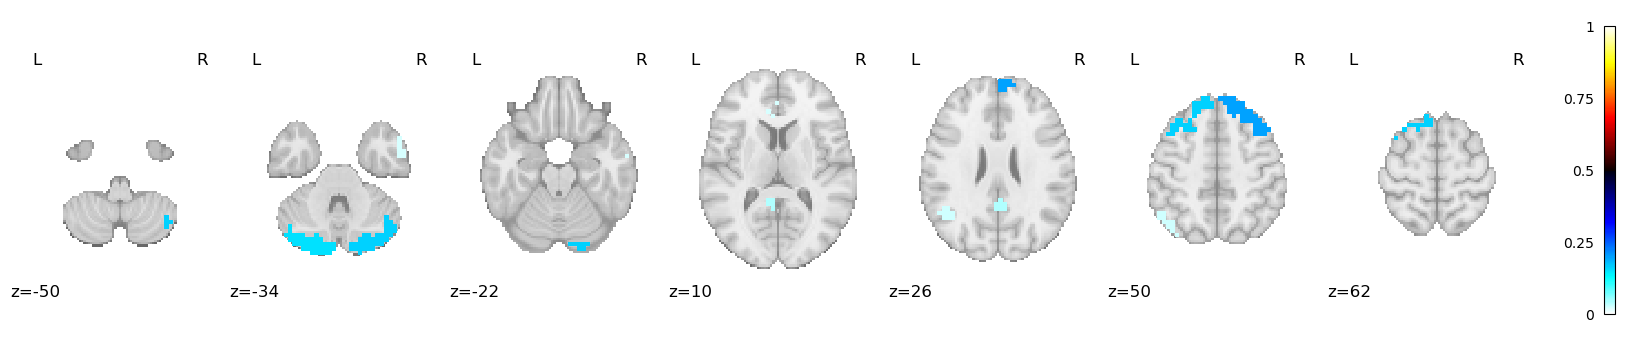

In [8]:
from nilearn.glm import cluster_level_inference

proportion_true_discoveries_img = cluster_level_inference(
    comput_constrast_outputs["z_score"], threshold=3.09, alpha=0.05
)

from nilearn import plotting

plotting.plot_stat_map(
    proportion_true_discoveries_img,
    threshold=0.0,
    display_mode="z",
    vmax=1,
    colorbar=True,
)



In [7]:
from nilearn.reporting import get_clusters_table
from nilearn import image
import numpy as np
from scipy.stats import t
from nilearn.image import get_data

t_map = comput_constrast_outputs["stat"]
p_map = comput_constrast_outputs["p_value"]

from nilearn.image import math_img
from scipy.stats import t

# 자유도 설정 (예: 표본 수 - 모수 수)
df = 137 - 5  # 적절한 자유도로 변경하세요
p_threshold = 0.05
# p < 0.05에 해당하는 t-값 임계값 계산 (양측 검정)
t_threshold = t.ppf(1 - p_threshold / 2, df)

print("p < 0.05에 해당하는 t 임계값:", t_threshold)

# t-값의 절대값이 임계값보다 큰 보셀만 남기기 위한 마스크 생성
t_abs_thresholded_map = math_img('np.abs(img) > {}'.format(1), img=t_map)
t_positive_thresholded_map = math_img('img > {}'.format(0), img=t_map)

# 원본 t_map에 마스크를 적용하여 t-값 임계값이 적용된 t_map 생성
t_thresholded_t_map = math_img('img1 * img2', img1=t_map, img2=t_abs_thresholded_map)
t_positive_t_map = math_img('img1 * img2', img1=t_map, img2=t_positive_thresholded_map)

# p_map에서 p < 0.05인 보셀만 남기기 위한 마스크 생성
p_thresholded_map = math_img('img < {}'.format(p_threshold), img=p_map)

# 원본 t_map에 마스크를 적용하여 p-값 임계값이 적용된 t_map 생성
p_thresholded_t_map = math_img('img1 * img2', img1=t_map, img2=p_thresholded_map)

# Extract min and max values from p_thresholded_t_map and t_thresholded_t_map
p_thresholded_t_data = get_data(p_thresholded_t_map)
t_thresholded_t_data = get_data(t_thresholded_t_map)
t_positive_t_data = get_data(t_positive_t_map)

# Calculate the min and max values
p_thresholded_t_min = np.min(p_thresholded_t_data)
p_thresholded_t_max = np.max(p_thresholded_t_data)
t_thresholded_t_min = np.min(t_thresholded_t_data)
t_thresholded_t_max = np.max(t_thresholded_t_data)
t_positive_t_min = np.min(t_positive_t_data)
t_positive_t_max = np.max(t_positive_t_data)

print("p_thresholded_t_map: min =", p_thresholded_t_min, "max =", p_thresholded_t_max)
print("t_thresholded_t_map: min =", t_thresholded_t_min, "max =", t_thresholded_t_max)
print("t_positive_t_map: min =", t_positive_t_min, "max =", t_positive_t_max)

p < 0.05에 해당하는 t 임계값: 1.9780988419057233
p_thresholded_t_map: min = 0.0 max = 5.674382868356026
t_thresholded_t_map: min = -5.493665231729011 max = 5.674382868356026
t_positive_t_map: min = 0.0 max = 5.674382868356026


In [12]:
from nilearn.datasets import fetch_atlas_aal
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import load_img
from nilearn.plotting import plot_stat_map
import numpy as np

# AAL atlas 다운로드
aal_atlas = fetch_atlas_aal(version='SPM12')
aal_labels = aal_atlas.labels  # ROI 이름 리스트
aal_indices = list(map(int, aal_atlas.indices))  # 인덱스를 정수로 변환

# AAL atlas 정보 출력
print(f"Labels: {aal_labels}")
print(f"Indices: {aal_indices}")



Dataset created in /home/changbae/nilearn_data/aal_SPM12

Labels: ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'O

Downloaded 212992 of 351343 bytes (60.6%,    0.7s remaining) ...done. (3 seconds, 0 min)
Extracting data from /home/changbae/nilearn_data/aal_SPM12/a4f2a6316ec7f29f771edef840308edf/aal_for_SPM12.tar.gz..... done.


In [45]:
import pandas as pd
from nilearn.reporting import get_clusters_table
from nilearn.image import load_img
from nilearn.image import new_img_like
from pathlib import Path
import numpy as np
import re
from rpy2.robjects.packages import importr
import rpy2.robjects as ro

# R package "label4MRI" import
label4MRI = importr('label4MRI')

# MNI 좌표를 AAL 및 BA 레이블로 변환하는 함수
def parse_mni_to_region_name(x, y, z):
    try:
        result = ro.r(f'mni_to_region_name(x = {x}, y = {y}, z = {z})')
        parsed_result = {
            'aal': {
                'label': result.rx2('aal.label')[0],
                'distance': result.rx2('aal.distance')[0],
            },
            'ba': {
                'label': result.rx2('ba.label')[0],
                'distance': result.rx2('ba.distance')[0],
            }
        }
        return parsed_result
    except Exception as e:
        print(f"Error parsing MNI coordinates ({x}, {y}, {z}): {e}")
        return {
            'aal': {'label': 'Unknown', 'distance': 0},
            'ba': {'label': 'Unknown', 'distance': 0}
        }

# 클러스터 테이블에서 각 좌표에 대해 AAL 및 BA 영역을 매핑하는 함수
def map_clusters_to_regions(cluster_table):
    aal_labels = []
    ba_labels = []
    aal_distances = []
    ba_distances = []

    for _, row in cluster_table.iterrows():
        x, y, z = row['X'], row['Y'], row['Z']
        
        # MNI 좌표에 대해 AAL 및 BA 레이블 매핑
        result = parse_mni_to_region_name(x, y, z)

        # AAL 및 BA 레이블과 거리를 저장
        aal_label = result['aal']['label']
        ba_label = result['ba']['label']
        aal_distance = result['aal']['distance']
        ba_distance = result['ba']['distance']

        # 디버깅을 위해 출력 (필요시 제거)
        print(f"Coordinates: ({x}, {y}, {z}), AAL: {aal_label}, BA: {ba_label}")

        aal_labels.append(aal_label)
        ba_labels.append(ba_label)
        aal_distances.append(aal_distance)
        ba_distances.append(ba_distance)

    # 클러스터 테이블에 AAL 및 BA 정보를 추가
    cluster_table['AAL Label'] = aal_labels
    cluster_table['AAL Distance'] = aal_distances
    cluster_table['BA Label'] = ba_labels
    cluster_table['BA Distance'] = ba_distances

    return cluster_table

from nilearn import image

# 클러스터 테이블과 label_maps 생성 함수 (양수/음수 클러스터 별도로 처리)
def process_clusters_with_label_maps(t_map, threshold=3.3):
    # 양수 클러스터 처리
    pos_cluster_table, pos_label_maps = get_clusters_table(
        t_map, stat_threshold=threshold, cluster_threshold=20, two_sided=False, return_label_maps=True
    )
    pos_cluster_table['Direction'] = 'positive'

    # 음수 클러스터 처리: t_map을 음수로 변환
    neg_t_map = image.math_img('-img', img=t_map)
    neg_cluster_table, neg_label_maps = get_clusters_table(
        neg_t_map, stat_threshold=threshold, cluster_threshold=20, two_sided=False, return_label_maps=True
    )
    neg_cluster_table['Direction'] = 'negative'
    # Peak Stat 값을 원래대로 음수로 변환
    neg_cluster_table['Peak Stat'] = -neg_cluster_table['Peak Stat']

    # 클러스터 테이블과 레이블 맵 병합
    cluster_table = pd.concat([pos_cluster_table, neg_cluster_table], ignore_index=True)
    label_maps = pos_label_maps + neg_label_maps

    if cluster_table.empty:
        print("No clusters found.")
        return None, None

    return cluster_table, label_maps

# 레이블 맵을 이진 마스크로 저장하는 함수 (양/음수 클러스터 및 AAL 레이블 포함)
def save_label_maps(cluster_table, label_maps, output_dir):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # 주 클러스터만 선택 (하위 클러스터 제외)
    main_clusters = cluster_table[cluster_table['Cluster Size (mm3)'].notna()].reset_index(drop=True)

    # 레이블 맵과 주 클러스터 테이블을 순회하며 파일 저장
    for idx, label_map in enumerate(label_maps):
        peak_stat = main_clusters.iloc[idx]['Peak Stat']
        cluster_id = main_clusters.iloc[idx]['Cluster ID']
        stat_type = main_clusters.iloc[idx]['Direction']

        # AAL 레이블 가져오기 (만약 비어있다면 Unknown으로 처리)
        aal_label = main_clusters.iloc[idx].get('AAL Label', 'Unknown')
        aal_label_clean = re.sub(r'[^a-zA-Z0-9_]', '_', str(aal_label))

        # 파일명에 양수/음수, 클러스터 ID 및 AAL 레이블 반영
        output_filename = output_dir / f"cluster_{stat_type}_{cluster_id}_{aal_label_clean}_label_map_{idx+1}.nii.gz"
        label_map.to_filename(str(output_filename))
        print(f"Saved {stat_type} cluster label map with AAL label '{aal_label}' to {output_filename}")



# t_map과 brain_mask_img 불러오기
t_map = comput_constrast_outputs["stat"]

# 클러스터 테이블과 레이블 맵 생성 (음수 포함, two_sided=True)
cluster_table, label_maps = process_clusters_with_label_maps(t_map)

# 클러스터 테이블을 AAL 및 BA 레이블로 업데이트
if cluster_table is not None:
    cluster_table = map_clusters_to_regions(cluster_table)

# 레이블 맵 저장 (양수/음수 클러스터 및 AAL 레이블 반영)
if label_maps:
    save_label_maps(cluster_table, label_maps, "./cluster_label_maps")

# 결과 테이블 출력
cluster_table


Coordinates: (-17.25, 22.75, 54.0), AAL: Frontal_Sup_L, BA: Left-BA6
Coordinates: (-33.25, 22.75, 50.0), AAL: Frontal_Mid_L, BA: Left-BA8
Coordinates: (-21.25, 42.75, 38.0), AAL: Frontal_Sup_L, BA: Left-BA9
Coordinates: (-9.25, 50.75, 42.0), AAL: Frontal_Sup_Medial_L, BA: Left-BA9
Coordinates: (-41.25, -53.25, 22.0), AAL: Temporal_Mid_L, BA: Left-BA39
Coordinates: (-49.25, -61.25, 42.0), AAL: Angular_L, BA: Left-BA39
Coordinates: (-49.25, -61.25, 54.0), AAL: Parietal_Inf_L, BA: Left-BA39
Coordinates: (42.75, 18.75, 54.0), AAL: Frontal_Mid_R, BA: Right-BA8
Coordinates: (34.75, 26.75, 50.0), AAL: Frontal_Mid_R, BA: Right-BA8
Coordinates: (10.75, 42.75, 46.0), AAL: Frontal_Sup_Medial_R, BA: Right-BA8
Coordinates: (22.75, 30.75, 50.0), AAL: Frontal_Sup_R, BA: Right-BA8
Coordinates: (-21.25, -85.25, -30.0), AAL: Cerebelum_Crus2_L, BA: Left-VisualAssoc (18)
Coordinates: (-9.25, -89.25, -42.0), AAL: Cerebelum_Crus2_L, BA: Left-VisualAssoc (18)
Coordinates: (-45.25, -81.25, -34.0), AAL: Cerebe

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),Direction,AAL Label,AAL Distance,BA Label,BA Distance
0,1,-17.25,22.75,54.0,5.674383,8896,positive,Frontal_Sup_L,0.000000,Left-BA6,0.000000
1,1a,-33.25,22.75,50.0,4.915901,,positive,Frontal_Mid_L,0.000000,Left-BA8,0.000000
2,1b,-21.25,42.75,38.0,4.811732,,positive,Frontal_Sup_L,0.000000,Left-BA9,0.000000
3,1c,-9.25,50.75,42.0,3.550875,,positive,Frontal_Sup_Medial_L,0.000000,Left-BA9,0.000000
4,2,-41.25,-53.25,22.0,5.246169,5568,positive,Temporal_Mid_L,0.000000,Left-BA39,1.000000
5,2a,-49.25,-61.25,42.0,4.316789,,positive,Angular_L,0.000000,Left-BA39,0.000000
6,2b,-49.25,-61.25,54.0,4.251028,,positive,Parietal_Inf_L,1.732051,Left-BA39,1.732051
7,3,42.75,18.75,54.0,5.016798,9600,positive,Frontal_Mid_R,0.000000,Right-BA8,2.236068
8,3a,34.75,26.75,50.0,4.923955,,positive,Frontal_Mid_R,0.000000,Right-BA8,1.000000
9,3b,10.75,42.75,46.0,4.912274,,positive,Frontal_Sup_Medial_R,0.000000,Right-BA8,0.000000


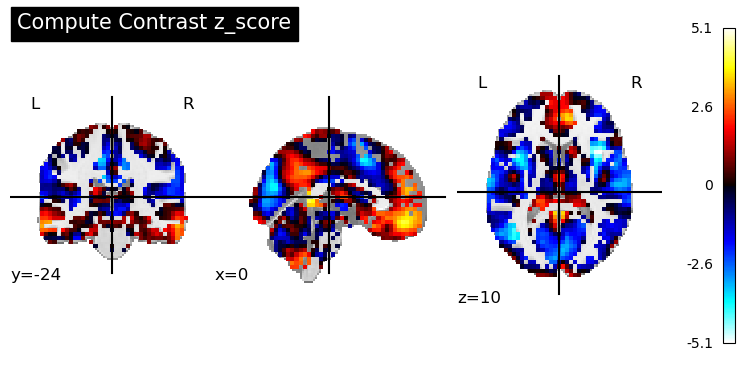

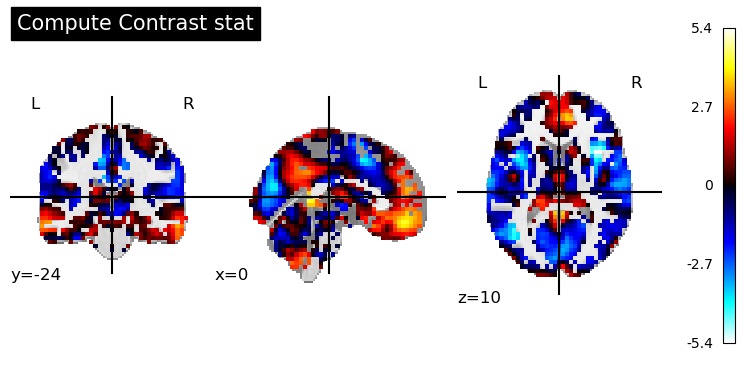

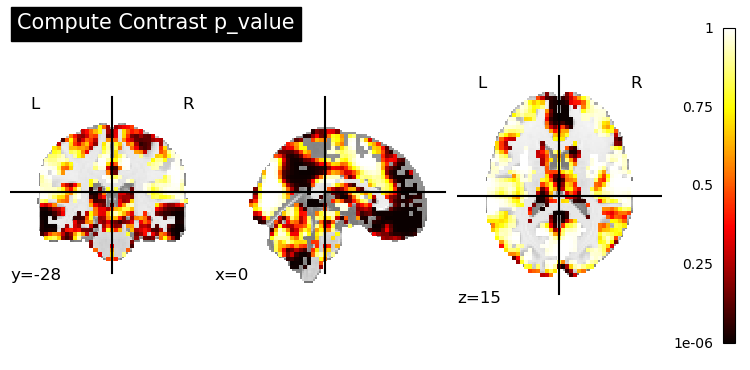

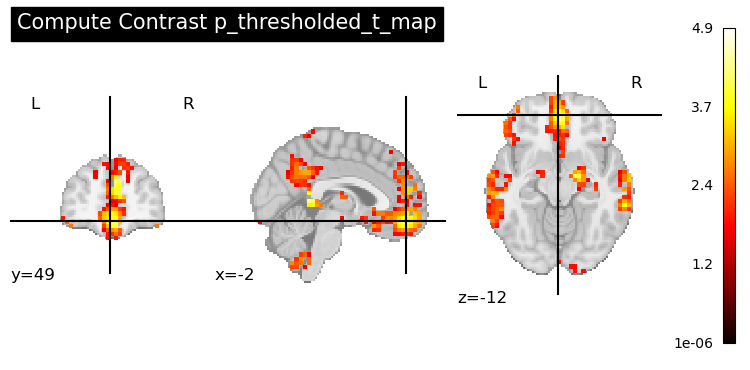

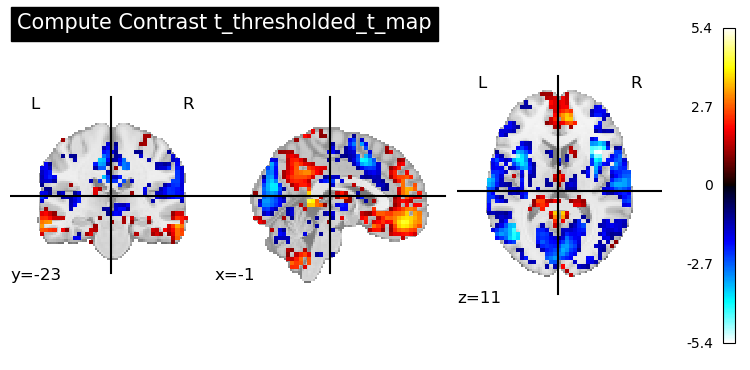

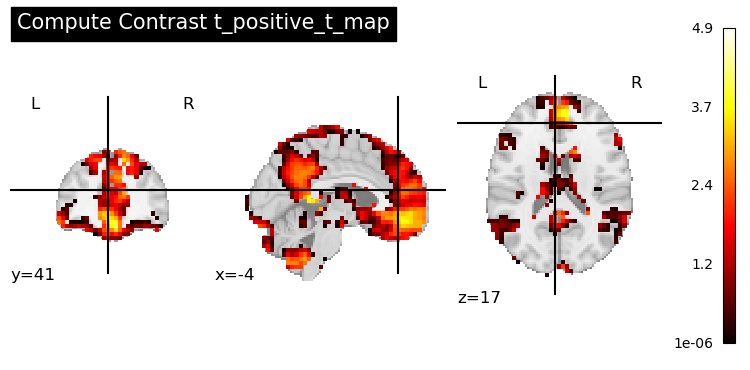

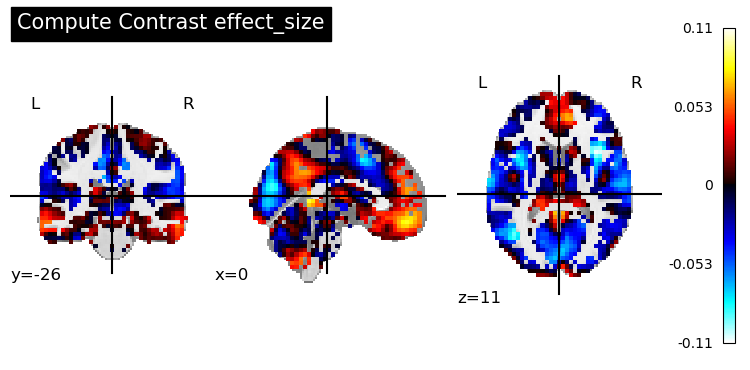

In [132]:
from scipy.stats import norm


plotting.plot_stat_map(
    comput_constrast_outputs["z_score"],
    title="Compute Contrast z_score",
)
plotting.plot_stat_map(
    comput_constrast_outputs["stat"],
    title="Compute Contrast stat",
)
plotting.plot_stat_map(
    comput_constrast_outputs["p_value"],
    cmap='hot',
    title="Compute Contrast p_value",
)
plotting.plot_stat_map(
    p_thresholded_t_map,
    cmap='hot',
    title="Compute Contrast p_thresholded_t_map",
)
plotting.plot_stat_map(
    t_thresholded_t_map,
    title="Compute Contrast t_thresholded_t_map",
)
plotting.plot_stat_map(
    t_positive_t_map,
    cmap='hot',
    title="Compute Contrast t_positive_t_map",
)
plotting.plot_stat_map(
    comput_constrast_outputs["effect_size"],
    title="Compute Contrast effect_size",
)

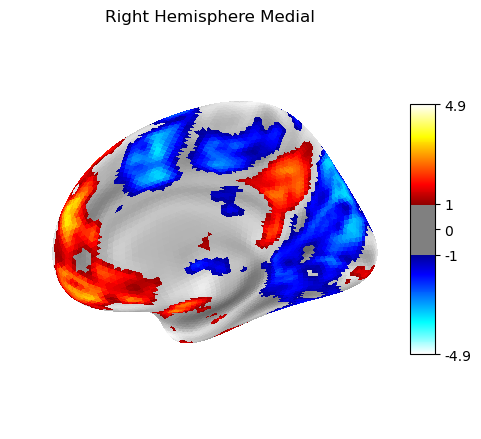

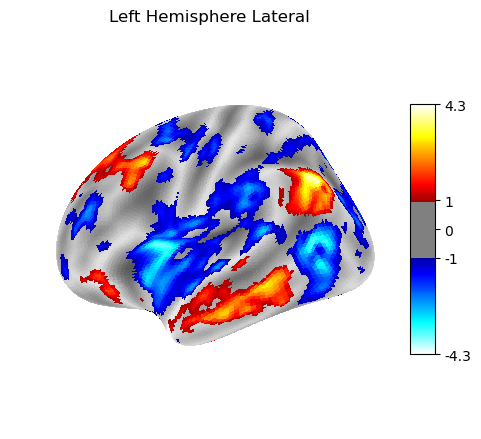

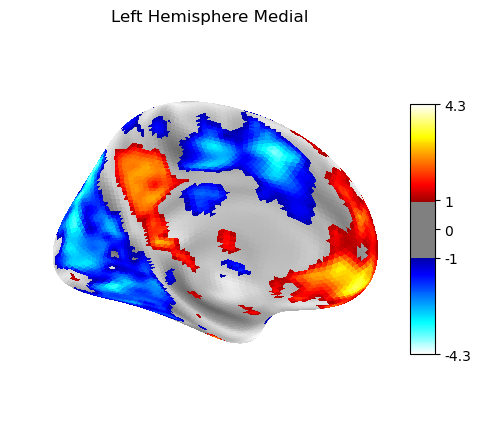

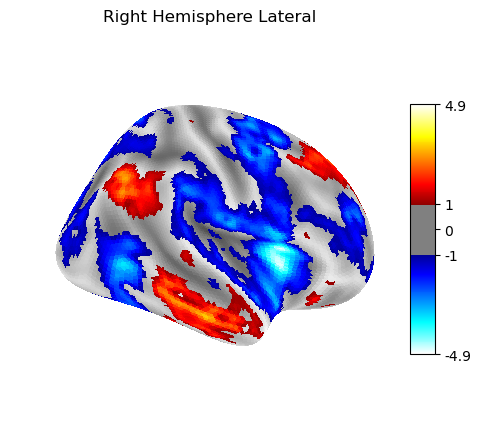

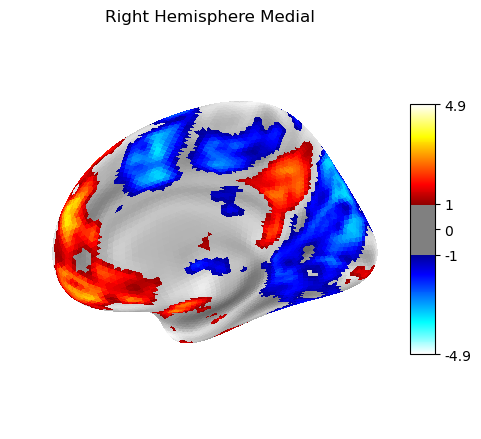

In [122]:
from nilearn import plotting, surface
from nilearn.datasets import fetch_surf_fsaverage
from nilearn.surface import vol_to_surf

# Load the fsaverage5 surface (used for plotting brain surfaces in Nilearn)
fsaverage = fetch_surf_fsaverage()
t_threshold = 1
# Project the masked t-map onto the surface for both hemispheres
texture_left = vol_to_surf(t_map, fsaverage.pial_left, interpolation='linear')
texture_right = vol_to_surf(t_map, fsaverage.pial_right, interpolation='linear')

# Plot the surface with the projected texture
# Plot the lateral surface for the left hemisphere
plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture_left, hemi='left', title='Left Hemisphere Lateral',
    threshold=t_threshold, bg_map=fsaverage.sulc_left, view='lateral'
)

# Plot the medial surface for the left hemisphere
plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture_left, hemi='left', title='Left Hemisphere Medial',
    threshold=t_threshold, bg_map=fsaverage.sulc_left, view='medial'
)

# Plot the lateral surface for the right hemisphere
plotting.plot_surf_stat_map(
    fsaverage.infl_right, texture_right, hemi='right', title='Right Hemisphere Lateral',
    threshold=t_threshold, bg_map=fsaverage.sulc_right, view='lateral'
)

# Plot the medial surface for the right hemisphere
plotting.plot_surf_stat_map(
    fsaverage.infl_right, texture_right, hemi='right', title='Right Hemisphere Medial',
    threshold=t_threshold, bg_map=fsaverage.sulc_right, view='medial'
)

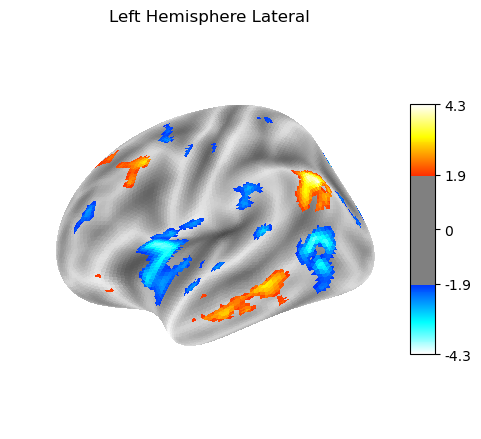

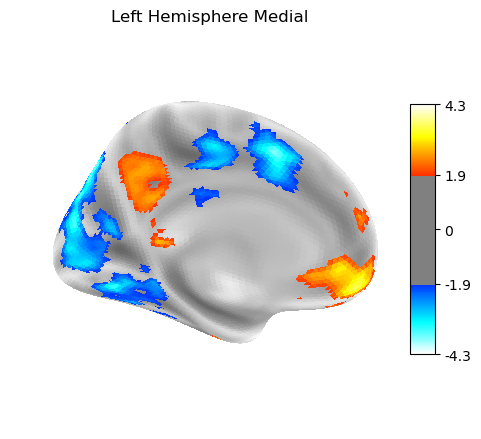

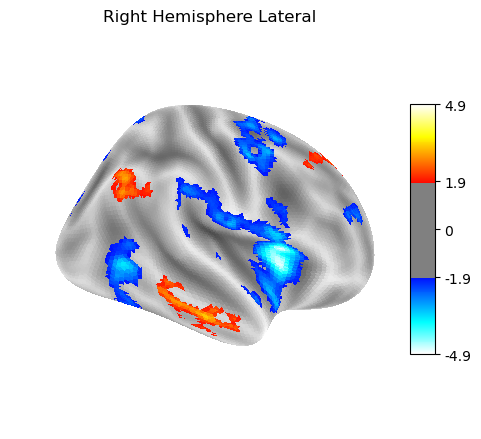

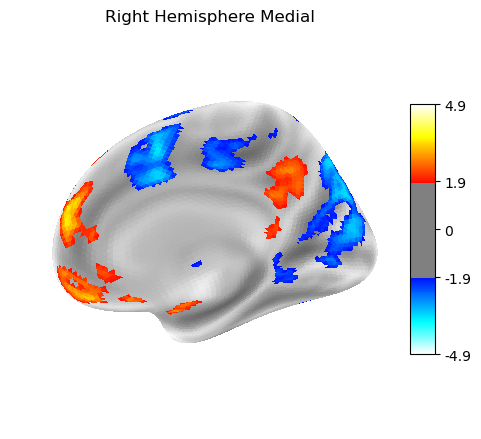

In [123]:
from nilearn import plotting, surface
from nilearn.datasets import fetch_surf_fsaverage
from nilearn.surface import vol_to_surf

# Load the fsaverage5 surface (used for plotting brain surfaces in Nilearn)
fsaverage = fetch_surf_fsaverage()
t_threshold = 1.9
# Project the masked t-map onto the surface for both hemispheres
texture_left = vol_to_surf(t_map, fsaverage.pial_left, interpolation='linear')
texture_right = vol_to_surf(t_map, fsaverage.pial_right, interpolation='linear')

# Plot the lateral surface for the left hemisphere
plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture_left, hemi='left', title='Left Hemisphere Lateral',
    threshold=t_threshold, bg_map=fsaverage.sulc_left, view='lateral'
)

# Plot the medial surface for the left hemisphere
plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture_left, hemi='left', title='Left Hemisphere Medial',
    threshold=t_threshold, bg_map=fsaverage.sulc_left, view='medial'
)

# Plot the lateral surface for the right hemisphere
plotting.plot_surf_stat_map(
    fsaverage.infl_right, texture_right, hemi='right', title='Right Hemisphere Lateral',
    threshold=t_threshold, bg_map=fsaverage.sulc_right, view='lateral'
)

# Plot the medial surface for the right hemisphere
plotting.plot_surf_stat_map(
    fsaverage.infl_right, texture_right, hemi='right', title='Right Hemisphere Medial',
    threshold=t_threshold, bg_map=fsaverage.sulc_right, view='medial'
)

# Show the plots
plotting.show()

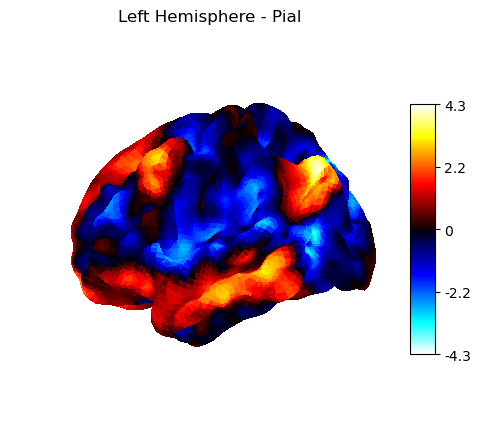

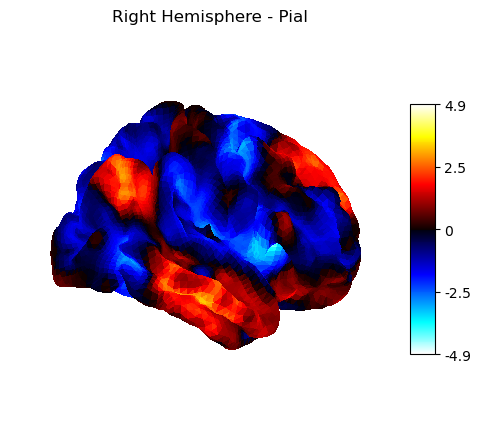

In [124]:
from nilearn import plotting, surface
from nilearn.datasets import fetch_surf_fsaverage
from nilearn.surface import vol_to_surf

# Load the fsaverage5 surface (used for plotting brain surfaces in Nilearn)
fsaverage = fetch_surf_fsaverage()
t_threshold = 0

# Project the masked t-map onto the surface for both hemispheres
texture_left = vol_to_surf(t_map, fsaverage.pial_left, interpolation='linear')
texture_right = vol_to_surf(t_map, fsaverage.pial_right, interpolation='linear')

# Plot the surface with the projected texture on the pial surface
plotting.plot_surf_stat_map(
    fsaverage.pial_left, texture_left, hemi='left', title='Left Hemisphere - Pial', 
    threshold=t_threshold, bg_map=fsaverage.sulc_left
)

plotting.plot_surf_stat_map(
    fsaverage.pial_right, texture_right, hemi='right', title='Right Hemisphere - Pial', 
    threshold=t_threshold, bg_map=fsaverage.sulc_right
)

# Show the plots
plotting.show()


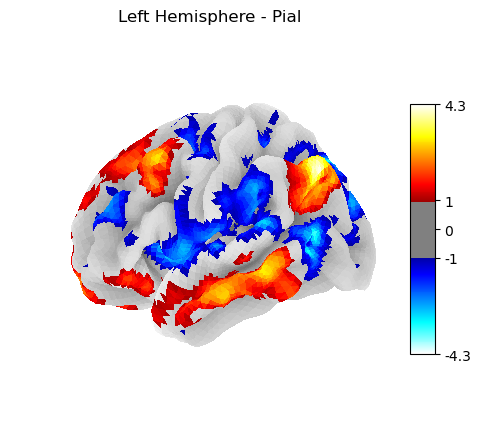

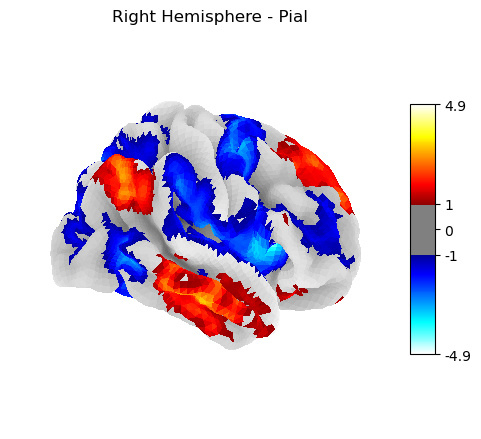

In [125]:
from nilearn import plotting, surface
from nilearn.datasets import fetch_surf_fsaverage
from nilearn.surface import vol_to_surf

# Load the fsaverage5 surface (used for plotting brain surfaces in Nilearn)
fsaverage = fetch_surf_fsaverage()
t_threshold = 1

# Project the masked t-map onto the surface for both hemispheres
texture_left = vol_to_surf(t_map, fsaverage.pial_left, interpolation='linear')
texture_right = vol_to_surf(t_map, fsaverage.pial_right, interpolation='linear')

# Plot the surface with the projected texture on the pial surface
plotting.plot_surf_stat_map(
    fsaverage.pial_left, texture_left, hemi='left', title='Left Hemisphere - Pial', 
    threshold=t_threshold, bg_map=fsaverage.sulc_left
)

plotting.plot_surf_stat_map(
    fsaverage.pial_right, texture_right, hemi='right', title='Right Hemisphere - Pial', 
    threshold=t_threshold, bg_map=fsaverage.sulc_right
)

# Show the plots
plotting.show()


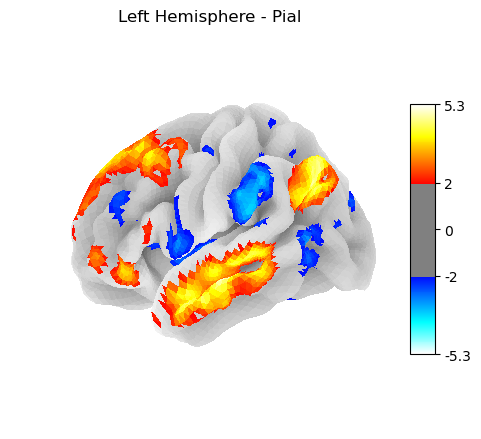

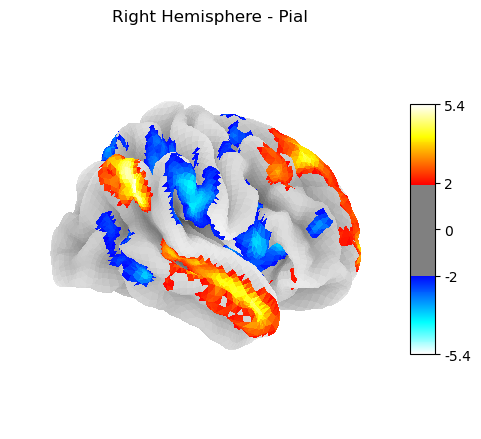

In [112]:
from nilearn import plotting, surface
from nilearn.datasets import fetch_surf_fsaverage
from nilearn.surface import vol_to_surf

# Load the fsaverage5 surface (used for plotting brain surfaces in Nilearn)
fsaverage = fetch_surf_fsaverage()
t_threshold = 2

# Project the masked t-map onto the surface for both hemispheres
texture_left = vol_to_surf(t_map, fsaverage.pial_left, interpolation='linear')
texture_right = vol_to_surf(t_map, fsaverage.pial_right, interpolation='linear')

# Plot the surface with the projected texture on the pial surface
plotting.plot_surf_stat_map(
    fsaverage.pial_left, texture_left, hemi='left', title='Left Hemisphere - Pial', 
    threshold=t_threshold, bg_map=fsaverage.sulc_left
)

plotting.plot_surf_stat_map(
    fsaverage.pial_right, texture_right, hemi='right', title='Right Hemisphere - Pial', 
    threshold=t_threshold, bg_map=fsaverage.sulc_right
)

# Show the plots
plotting.show()


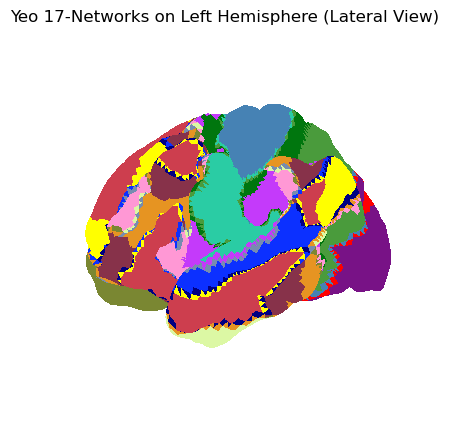

Network Labels and Corresponding Indexes:
Network 0: FreeSurfer_Defined_Medial_Wall
Network 1: 17Networks_1
Network 2: 17Networks_2
Network 3: 17Networks_3
Network 4: 17Networks_4
Network 5: 17Networks_5
Network 6: 17Networks_6
Network 7: 17Networks_7
Network 8: 17Networks_8
Network 9: 17Networks_9
Network 10: 17Networks_10
Network 11: 17Networks_11
Network 12: 17Networks_12
Network 13: 17Networks_13
Network 14: 17Networks_14
Network 15: 17Networks_15
Network 16: 17Networks_16
Network 17: 17Networks_17


In [113]:
# Import necessary modules
from nilearn import datasets, plotting, surface
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import nibabel as nib
import numpy as np

# Fetch fsaverage5 template for plotting
fsaverage = datasets.fetch_surf_fsaverage()

# Load Yeo 17-network parcellation for the left hemisphere
parcellation_file = 'lh.Yeo2011_17Networks_N1000.annot'

# Load the parcellation data (labels, color table, names)
labels, ctab, names = nib.freesurfer.read_annot(parcellation_file)

# Create a discrete colormap based on the number of networks
n_networks = len(names)  # Number of unique networks
colors = ctab[:, :3] / 255.  # Normalize RGB colors from 0-255 to 0-1
discrete_cmap = ListedColormap(colors)  # Convert to ListedColormap

# Plot the 17-network parcellation on the left hemisphere using plot_surf
plotting.plot_surf(
    surf_mesh=fsaverage['pial_left'],  # Pial surface for left hemisphere
    surf_map=labels,  # Yeo 17-network parcellation
    bg_map=fsaverage['sulc_left'],  # Sulcal depth map for shading
    hemi='left',  # Plot the left hemisphere
    view='lateral',  # Lateral view for visibility
    cmap=discrete_cmap,  # Apply the discrete colormap
    colorbar=False,  # Do not display the colorbar (labeling manually)
    title="Yeo 17-Networks on Left Hemisphere (Lateral View)",
    darkness=0.6  # Adjust the darkness for better contrast
)

# Show the plot
plt.show()

# Print the network names and corresponding indices
print("Network Labels and Corresponding Indexes:")
for idx, name in enumerate(names):
    print(f"Network {idx}: {name.decode('utf-8')}")


In [114]:
# Import required libraries
from nilearn import datasets, plotting
import numpy as np

# Fetch the Yeo 7-network parcellation atlas
yeo = datasets.fetch_atlas_surf_yeo()

# Get fsaverage5 surface data for visualization
fsaverage = datasets.fetch_surf_fsaverage()

# Create multiple views of the parcellation
def plot_surface_views(surface, parcellation, title):
    views = ['lateral', 'medial']
    for view in views:
        plotting.plot_surf_roi(
            surface,
            roi_map=parcellation,
            hemi='left',
            view=view,
            bg_map=fsaverage['sulc_left'],
            bg_on_data=True,
            darkness=0.5,
            title=f'{title} - {view} view'
        )

# Plot on pial surface
plot_surface_views(
    fsaverage['pial_left'],
    yeo['yeo_7_liberal']['map_left'],
    'Yeo 7-Network Parcellation (Pial Surface)'
)

# Plot on inflated surface for better sulci visualization
plot_surface_views(
    fsaverage['infl_left'],
    yeo['yeo_7_liberal']['map_left'],
    'Yeo 7-Network Parcellation (Inflated Surface)'
)

# Create a figure showing the network labels
network_names = [
    'Visual',
    'Somatomotor',
    'Dorsal Attention',
    'Ventral Attention',
    'Limbic',
    'Frontoparietal',
    'Default Mode'
]

# Display color scheme and network names
plotting.show_surf_labels(
    fsaverage['infl_left'],
    yeo['yeo_7_liberal']['map_left'],
    labels=network_names,
    colors=None,  # Will use default colors
    hemi='left',
    view='lateral'
)

AttributeError: module 'nilearn.datasets' has no attribute 'fetch_atlas_surf_yeo'

In [ ]:
from nilearn import plotting, datasets, surface
from nilearn.surface import vol_to_surf

# Load the fsaverage template (for surface visualization)
fsaverage = datasets.fetch_surf_fsaverage()

# Load Yeo 17-network atlas
atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011()
atlas_yeo_17 = atlas_yeo_2011.thick_17

# Project the volumetric Yeo atlas onto the fsaverage surface (left hemisphere)
texture_left = vol_to_surf(atlas_yeo_17, fsaverage.pial_left)

# Project the volumetric Yeo atlas onto the fsaverage surface (right hemisphere)
texture_right = vol_to_surf(atlas_yeo_17, fsaverage.pial_right)

# Plot left hemisphere surface with Yeo 17 networks
plotting.view_surf(fsaverage.infl_left, texture_left, hemi='left',
                   title='Yeo 17 Networks - Left Hemisphere', colorbar=True)

# Plot right hemisphere surface with Yeo 17 networks
plotting.view_surf(fsaverage.infl_right, texture_right, hemi='right',
                   title='Yeo 17 Networks - Right Hemisphere', colorbar=True)

# You can also plot both hemispheres side by side
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left,
                            hemi='left', title='Yeo 17 Networks - Left Hemisphere',
                            colorbar=True, bg_map=fsaverage.sulc_left)

plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right,
                            hemi='right', title='Yeo 17 Networks - Right Hemisphere',
                            colorbar=True, bg_map=fsaverage.sulc_right)


TypeError: view_surf() got an unexpected keyword argument 'hemi'

In [7]:
from nilearn import image, plotting
from nilearn.glm.second_level import non_parametric_inference
import numpy as np
# Set the cluster-forming threshold (voxel-level p-value)
brain_mask_filename = f"../../template/all_final_group_mask_8mm.nii.gz"
brain_mask_img = load_img(brain_mask_filename)
# Number of permutations
n_perm = 10000
# Perform non-parametric inference with cluster-level correction
outputs = non_parametric_inference(
    second_level_input=z_maps,
    design_matrix=design_matrix,
    second_level_contrast=variable,
    n_perm=n_perm,
    two_sided_test=True,
    mask=brain_mask_img,
    smoothing_fwhm=None,
    n_jobs=-1,
    threshold=0.001,
    #tfce=True,
    verbose=1,
)

Fitting second level model...
Computation of second level model done in 0.02696847915649414 seconds
/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/nilearn/mass_univariate/permuted_least_squares.py:986: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [20]:
from nilearn import plotting, image
from nilearn.reporting import get_clusters_table
import numpy as np

# Assuming `outputs` is the result from non_parametric_inference
# Thresholding the output map to voxel p < 0.005
voxel_p_threshold = 0.05  # p-value for voxels
voxel_logp_threshold = -np.log10(voxel_p_threshold)  # log10 scale for threshold
print(voxel_logp_threshold)
# The statistical map from the non_parametric_inference
stat_img = outputs["logp_max_t"]  # Use the resulting map from non_parametric_inference

# Get the table of clusters from the thresholded statistical map
# Set the cluster size threshold to None, as we will filter them manually by p-value later
cluster_table = get_clusters_table(
    stat_img=stat_img,
    stat_threshold=voxel_logp_threshold,  # Threshold for voxel-level p-value
    cluster_threshold=None,  # No minimum cluster size threshold yet
    #two_sided=True,  # Two-sided test, looking for both positive and negative clusters
)

# Display the table with significant clusters
print(cluster_table)

1.3010299956639813
   Cluster ID      X      Y     Z  Peak Stat  Cluster Size (mm3)
0           1 -17.25  22.75  54.0   1.924496                  64
1           2  34.75   6.75  14.0   1.655651                 128
2           3  50.75  -1.25  10.0   1.527287                  64
3           4 -41.25  -9.25  14.0   1.426012                  64


In [25]:
import numpy as np
from nilearn.image import get_data

# Get the data from the statistical image
stat_img_data = get_data(outputs["t"])

# Now, calculate the minimum and maximum values
min_value = np.min(stat_img_data)
max_value = np.max(stat_img_data)

print(f"Min value: {min_value}, Max value: {max_value}")

Min value: -5.493665231729011, Max value: 5.6743828683560285


In [22]:
import nibabel as nib
import numpy as np
from nilearn.image import get_data, new_img_like

# Get the data from the statistical image
stat_img_data = get_data(outputs["logp_max_size"])

# Now, calculate the minimum and maximum values
min_value = np.min(stat_img_data)
max_value = np.max(stat_img_data)

print(f"Min value: {min_value}, Max value: {max_value}")

# Create a new NIfTI image using the existing image's affine (coordinate system)
new_stat_img = new_img_like(outputs["logp_max_size"], stat_img_data)

# Save the new NIfTI image as stat_map.nii.gz
nib.save(new_stat_img, 'stat_map.nii.gz')

Min value: 0.0, Max value: 2.6777807052660827


In [48]:
from nilearn.reporting import get_clusters_table
from nilearn import image
import numpy as np
from scipy.stats import t
from nilearn.image import get_data

t_map = outputs["t"]
p_map = outputs["logp_max_t"]

from nilearn.image import math_img
from scipy.stats import t

# 자유도 설정 (예: 표본 수 - 모수 수)
df = 137 - 5  # 적절한 자유도로 변경하세요
p_threshold = 0.01
# p < 0.05에 해당하는 t-값 임계값 계산 (양측 검정)
t_threshold = t.ppf(1 - p_threshold / 2, df)

print("p < 0.05에 해당하는 t 임계값:", t_threshold)

# t-값의 절대값이 임계값보다 큰 보셀만 남기기 위한 마스크 생성
t_abs_thresholded_map = math_img('np.abs(img) > {}'.format(t_threshold), img=t_map)

# 원본 t_map에 마스크를 적용하여 t-값 임계값이 적용된 t_map 생성
t_thresholded_t_map = math_img('img1 * img2', img1=t_map, img2=t_abs_thresholded_map)

# p_map에서 p < 0.05인 보셀만 남기기 위한 마스크 생성
p_thresholded_map = math_img('img < {}'.format(p_threshold), img=p_map)

# 원본 t_map에 마스크를 적용하여 p-값 임계값이 적용된 t_map 생성
p_thresholded_t_map = math_img('img1 * img2', img1=t_map, img2=p_thresholded_map)

# Extract min and max values from p_thresholded_t_map and t_thresholded_t_map
p_thresholded_t_data = get_data(p_thresholded_t_map)
t_thresholded_t_data = get_data(t_thresholded_t_map)

# Calculate the min and max values
p_thresholded_t_min = np.min(p_thresholded_t_data)
p_thresholded_t_max = np.max(p_thresholded_t_data)
t_thresholded_t_min = np.min(t_thresholded_t_data)
t_thresholded_t_max = np.max(t_thresholded_t_data)

print("p_thresholded_t_map: min =", p_thresholded_t_min, "max =", p_thresholded_t_max)
print("t_thresholded_t_map: min =", t_thresholded_t_min, "max =", t_thresholded_t_max)

p < 0.05에 해당하는 t 임계값: 2.613588241960226
p_thresholded_t_map: min = -3.404799684218453 max = 3.405062859463443
t_thresholded_t_map: min = -5.122327644008507 max = 6.2505313507942875


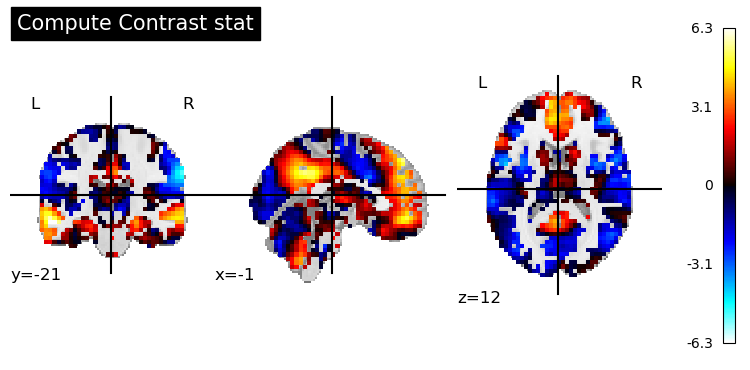

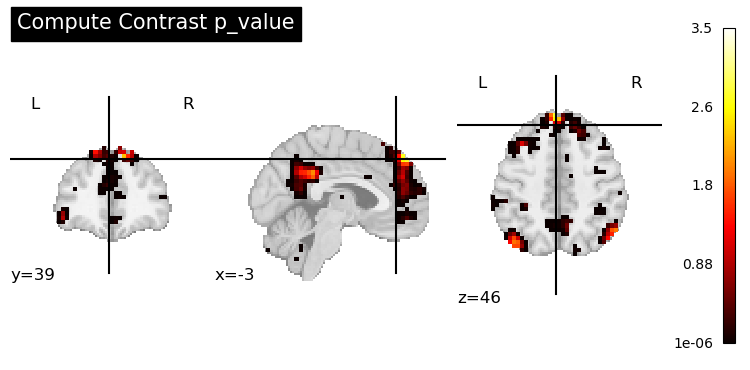

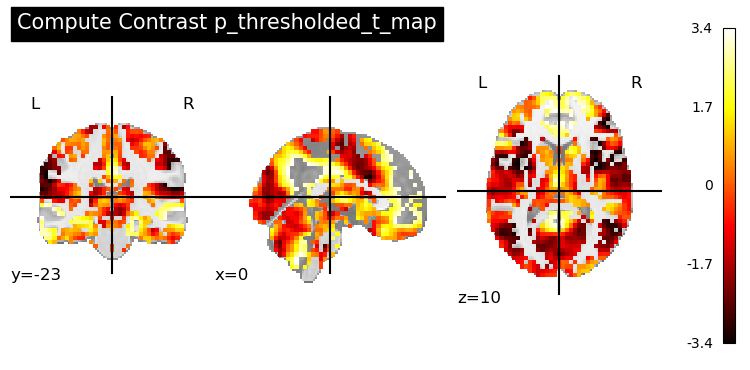

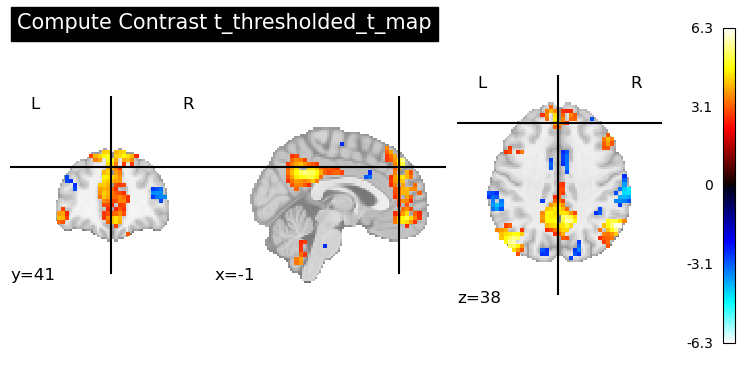

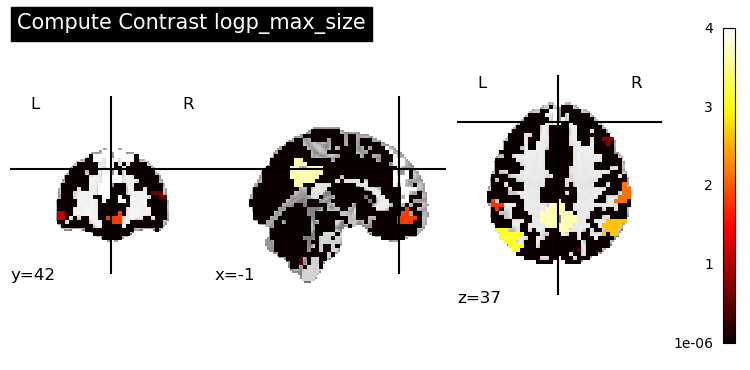

In [49]:
from scipy.stats import norm


plotting.plot_stat_map(
    outputs["t"],
    title="Compute Contrast stat",
)
plotting.plot_stat_map(
    outputs["logp_max_t"],
    cmap='hot',
    title="Compute Contrast p_value",
)
plotting.plot_stat_map(
    p_thresholded_t_map,
    cmap='hot',
    title="Compute Contrast p_thresholded_t_map",
)
plotting.plot_stat_map(
    t_thresholded_t_map,
    title="Compute Contrast t_thresholded_t_map",
)
plotting.plot_stat_map(
    outputs["logp_max_size"],
    cmap='hot',
    title="Compute Contrast logp_max_size",
)


In [24]:
import numpy as np
import nibabel as nib

# Load the data from the t-map
t_map_data = outputs["t"].get_fdata()

# Apply the threshold: keep values above 1.9 and below -1.9, set others to 0
threshold = 1.9
thresholded_data = np.where((t_map_data > threshold) | (t_map_data < -threshold), t_map_data, 0)

# Create a new NIfTI image with the thresholded data, using the affine from the original t-map
new_img = nib.Nifti1Image(thresholded_data, affine=outputs["t"].affine)

# Save the thresholded image as a NIfTI file
nib.save(new_img, 'thresholded_t_map_1.9.nii.gz')

print("NIfTI file saved as 'thresholded_t_map_1.9.nii.gz'")


NIfTI file saved as 'thresholded_t_map_1.9.nii.gz'


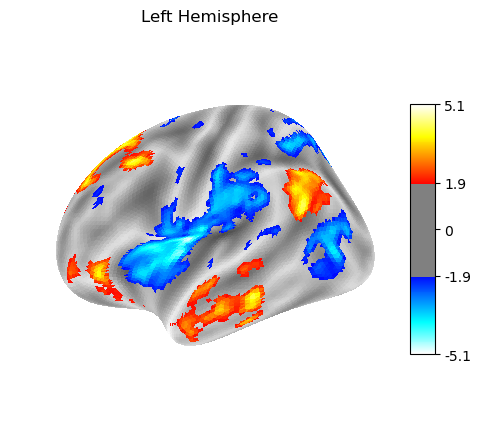

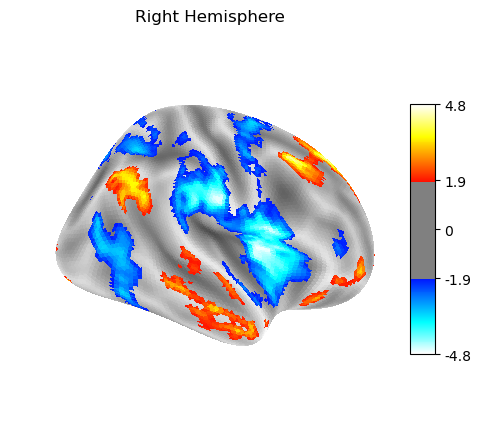

In [23]:
from nilearn import plotting, surface
from nilearn.datasets import fetch_surf_fsaverage
from nilearn.surface import vol_to_surf

# Load the fsaverage5 surface (used for plotting brain surfaces in Nilearn)
fsaverage = fetch_surf_fsaverage()
t_threshold = 1.9
# Project the masked t-map onto the surface for both hemispheres
texture_left = vol_to_surf(outputs["t"], fsaverage.pial_left, interpolation='linear')
texture_right = vol_to_surf(outputs["t"], fsaverage.pial_right, interpolation='linear')

# Plot the surface with the projected texture
plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture_left, hemi='left', title='Left Hemisphere', 
    threshold=t_threshold, bg_map=fsaverage.sulc_left
)


plotting.plot_surf_stat_map(
    fsaverage.infl_right, texture_right, hemi='right', title='Right Hemisphere',
    threshold=t_threshold, bg_map=fsaverage.sulc_right
)

# Show the plots
plotting.show()

  Cluster ID      X     Y     Z  Peak Stat Cluster Size (mm3)
0          1  34.75  6.75  14.0   3.301073               2816
1         1a  34.75 -1.25   6.0   3.221892                   
2         1b  50.75 -1.25  10.0   3.221892                   
3         1c  54.75  6.75   6.0   3.221892                   


/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/nilearn/plotting/find_cuts.py:148: UserWarning: Could not determine cut coords: All voxels were masked by the thresholding. Returning the center of mass instead.
  warnings.warn(
/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


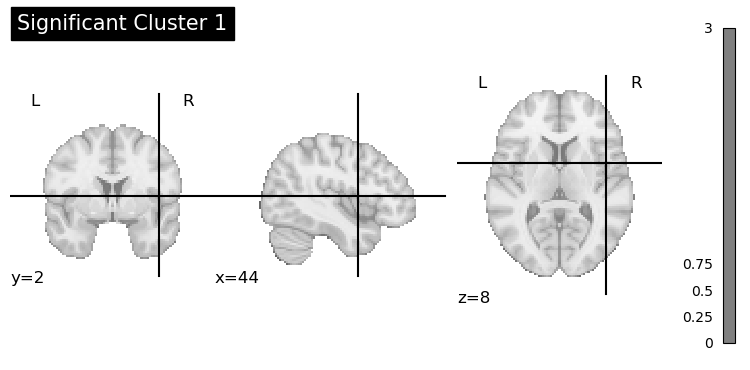

In [78]:
from nilearn import plotting, image, reporting

# Define the threshold for p-values (e.g., 0.05) and calculate its logp equivalent
p_value_threshold = 0.001
logp_cutoff = -np.log10(p_value_threshold)

# Generate the significant cluster mask based on the cutoff threshold
significant_clusters_img = image.math_img(f"img > {logp_cutoff}", img=outputs['logp_max_tfce'])

# Apply nilearn's get_clusters_table function
clusters_table, label_maps = reporting.get_clusters_table(
    stat_img=outputs['logp_max_tfce'],    # The statistical image (e.g., logp map)
    stat_threshold=logp_cutoff,           # Cluster-forming threshold in the same scale as the statistical image
    #cluster_threshold=10,                 # Optional: cluster size threshold (e.g., 10 voxels)
    two_sided=False,                      # Whether to evaluate both tails or only positive values
    min_distance=8.0,                     # Minimum distance between subpeaks (default 8mm)
    return_label_maps=True                # Return the cluster label maps
)

# Print out the clusters table for reference
print(clusters_table)

# Visualize each cluster based on the cluster label maps
for cluster_idx, cluster_img in enumerate(label_maps):
    # Visualize the cluster
    plotting.plot_stat_map(
        cluster_img,
        title=f"Significant Cluster {cluster_idx + 1}",
        threshold=logp_cutoff,
        display_mode='ortho',
        colorbar=True,
        cmap='Reds'
    )


   Cluster ID      X      Y     Z  Peak Stat Cluster Size (mm3)
0           1  34.75   6.75  14.0   3.301073              10560
1          1a  34.75  -1.25   6.0   3.221892                   
2          1b  50.75  -1.25  10.0   3.221892                   
3          1c  54.75   6.75   6.0   3.221892                   
4           2  62.75 -17.25  26.0   2.619832               4608
5           3 -41.25  -9.25  14.0   2.522922               1856
6           4 -17.25  22.75  54.0   2.468565               1024
7           5  34.75  26.75  50.0   2.337286               3200
8          5a  10.75  42.75  46.0   2.318802                   
9          5b  42.75  18.75  54.0   2.318802                   
10         5c  18.75  38.75  46.0   2.267650                   
11          6 -33.25  22.75  50.0   2.107949                320
12          7 -53.25 -13.25  14.0   2.075764                128
13          8 -65.25 -21.25  42.0   2.050653                192
14          9  30.75  26.75  10.0   2.00

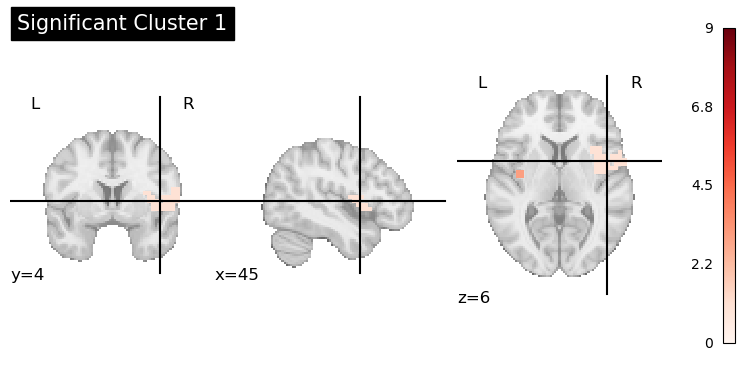

In [66]:
import numpy as np
from nilearn import plotting, image, reporting

# Set a threshold for the statistical map
threshold_value = 2  # Example threshold for significant clusters

# Use get_clusters_table to extract clusters and their statistics
clusters_table = reporting.get_clusters_table(
    stat_img=outputs['logp_max_tfce'],  # The statistical image you want to analyze
    stat_threshold=threshold_value,  # Threshold applied to the statistical image
    cluster_threshold=None,  # No minimum size threshold for clusters
    two_sided=False,  # One-sided thresholding (positive values only)
    min_distance=8.0,  # Minimum distance between subpeaks, in millimeters
    return_label_maps=True  # Return the cluster label maps as well
)

# The resulting table is a pandas DataFrame containing cluster statistics
print(clusters_table[0])  # Print the cluster statistics table

# Extract the label maps from the function's output
label_maps = clusters_table[1]  # The list of cluster label maps

# Loop through the clusters and visualize each one
for cluster_idx, cluster_img in enumerate(label_maps, start=1):
    plotting.plot_stat_map(
        cluster_img,
        title=f"Significant Cluster {cluster_idx}",
        threshold=0,  # No additional threshold to show full clusters
        display_mode='ortho',  # Ortho view to show sagittal, coronal, and axial slices
        colorbar=True,  # Show colorbar
        cmap='Reds'  # Colormap to visualize the cluster in red
    )

plotting.show()


In [68]:
from nilearn import image

# 음의 로그10 p-값을 원래 p-값으로 변환
cluster_pval_img = image.math_img(
    "np.power(10, -img)", img=outputs['logp_max_tfce']
)
from nilearn import reporting

# 클러스터 레이블 이미지 생성
clusters_table = reporting.get_clusters_table(
    stat_img=outputs['logp_max_tfce'],
    stat_threshold=-np.log10(0.05),  # 예: p < 0.05 수준에서 클러스터 추출
    cluster_threshold=0,  # 최소 클러스터 크기 설정 (0으로 설정하여 모든 클러스터 포함)
    two_sided=False,
    min_distance=8.0,
    return_label_maps=True
)

# 레이블 이미지 추출
label_img = clusters_table[1][0]
import numpy as np
import pandas as pd

# 레이블 데이터와 p-값 데이터 추출
label_data = label_img.get_fdata()
pval_data = cluster_pval_img.get_fdata()

# 클러스터 ID 목록 (0은 배경이므로 제외)
cluster_ids = np.unique(label_data)
cluster_ids = cluster_ids[cluster_ids != 0]

# 결과를 저장할 리스트 초기화
significant_clusters = []

for cluster_id in cluster_ids:
    # 해당 클러스터의 보컬 마스크 생성
    cluster_mask = label_data == cluster_id

    # 해당 보컬들의 p-값 추출
    cluster_pvals = pval_data[cluster_mask]

    # 클러스터의 최소 p-값 계산
    min_pval = np.min(cluster_pvals)

    # 클러스터의 크기 계산 (보컬 수 또는 mm3 단위로 변환 가능)
    cluster_size = np.sum(cluster_mask)

    # 유의한 클러스터인지 판단 (예: p < 0.05)
    if min_pval < 0.05:
        significant_clusters.append({
            'Cluster ID': int(cluster_id),
            'Min p-value': min_pval,
            'Cluster Size (voxels)': cluster_size
        })

# 결과를 데이터프레임으로 변환
significant_clusters_df = pd.DataFrame(significant_clusters)

print(significant_clusters_df)


    Cluster ID  Min p-value  Cluster Size (voxels)
0            1     0.000500                    454
1            2     0.003000                    173
2            3     0.003400                    140
3            4     0.004600                    154
4            5     0.008899                    100
5            6     0.016798                     83
6            7     0.024698                     21
7            8     0.031297                     20
8            9     0.036896                      7
9           10     0.039796                      4
10          11     0.040496                      3
11          12     0.040696                      2
12          13     0.040696                     14
13          14     0.044496                      3


In [ ]:
from nilearn.image import new_img_like
import scipy.stats as stats

# Load the data using outputs
t_data = outputs["t"].get_fdata()

# Calculate the 97.5% critical t-value (two-tailed)
# You need to provide the degrees of freedom (df) for your analysis
df = outputs["t"].shape[0] - 1  # Assuming df is number of samples - 1
t_cutoff = stats.t.ppf(0.975, df)

# Identify significant positive effects (t > cutoff)
positive_effects = t_data > t_cutoff

# Identify significant negative effects (t < -cutoff)
negative_effects = t_data < -t_cutoff

# Create images of positive and negative effects using nilearn
positive_effects_img = new_img_like(outputs["t"], positive_effects.astype(int))
negative_effects_img = new_img_like(outputs["t"], negative_effects.astype(int))

# Save or process these images further


/tmp/ipykernel_921134/1717427628.py:19: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  positive_effects_img = new_img_like(outputs["t"], positive_effects.astype(int))
/tmp/ipykernel_921134/1717427628.py:20: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  negative_effects_img = new_img_like(outputs["t"], negative_effects.astype(int))


In [122]:
from nilearn import plotting

# Visualize the unthresholded t-map
view = plotting.view_img(outputs["logp_max_t"], title="logp_max_t")

# Save the interactive HTML file
view.save_as_html("logp_max_t.html")

# Optionally, display the view in your browser (if running locally)
view.open_in_browser()

/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [123]:
from nilearn import plotting

# Visualize the unthresholded t-map
view = plotting.view_img(outputs["t"], title="t")

# Save the interactive HTML file
view.save_as_html("t.html")

# Optionally, display the view in your browser (if running locally)
view.open_in_browser()

/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [124]:
from nilearn import image, plotting
import numpy as np

# Define the threshold value for p < 0.05 in log10 scale
p_threshold_log = -np.log10(0.05)

# Apply the threshold to the logp_max_t map
thresholded_logp_max_t = image.threshold_img(outputs["logp_max_t"], threshold=p_threshold_log)

# Use the thresholded logp_max_t to mask the corresponding t-map
thresholded_t_map = image.math_img("img1 * (img2 > {})".format(p_threshold_log), 
                                   img1=outputs["t"], img2=outputs["logp_max_t"])

# Visualize the thresholded t-map
view = plotting.view_img(thresholded_t_map, title="Thresholded t-map (p < 0.05)")

# Save the interactive HTML file
view.save_as_html("thresholded_t_map_p_0_05.html")

# Optionally, display the view in your browser (if running locally)
view.open_in_browser()


/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [125]:
from nilearn import plotting
import numpy as np

# Load the t and log(p) data
t_img = outputs["t"]
p_img = outputs["logp_max_t"]
p_data = p_img.get_fdata()

# Define the significance threshold (p < 0.05)
significance_threshold = -np.log10(0.05)

# Mask where the p-value is significant (p < 0.05)
significant_mask = p_data > significance_threshold

# Apply the mask to the t-map (setting non-significant areas to 0)
t_data = t_img.get_fdata()
thresholded_t_data = np.where(significant_mask, t_data, 0)

# Create a new image for the thresholded t-map
thresholded_t_img = new_img_like(t_img, thresholded_t_data)

# Visualize the thresholded t-map
view = plotting.view_img(thresholded_t_img, title="Thresholded T-Map (p < 0.05)")

# Save the interactive HTML file
view.save_as_html("thresholded_t_map_p0.05.html")

# Optionally, display the view in your browser (if running locally)
view.open_in_browser()


/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


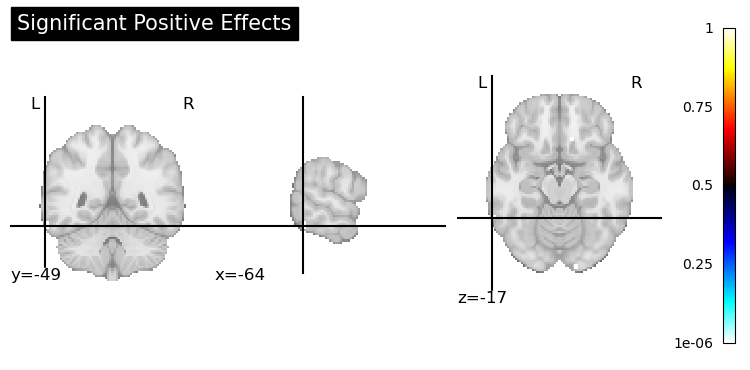

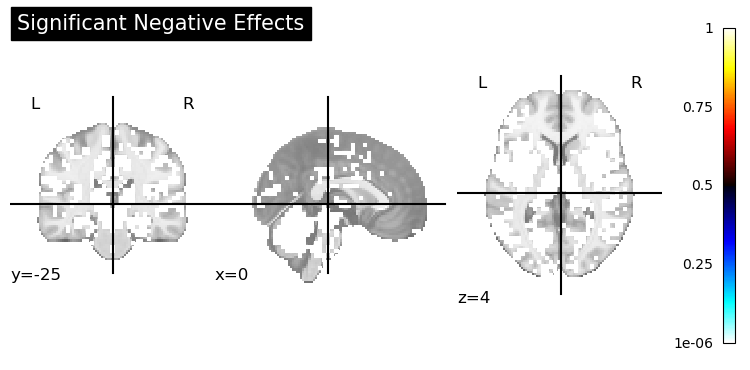

In [ ]:
from nilearn import plotting

# Plot positive effects
plotting.plot_stat_map(
    positive_effects_img,
    title='Significant Positive Effects',
    display_mode='ortho',
    colorbar=True,
)

# Plot negative effects
plotting.plot_stat_map(
    negative_effects_img,
    title='Significant Negative Effects',
    display_mode='ortho',
    colorbar=True,
)

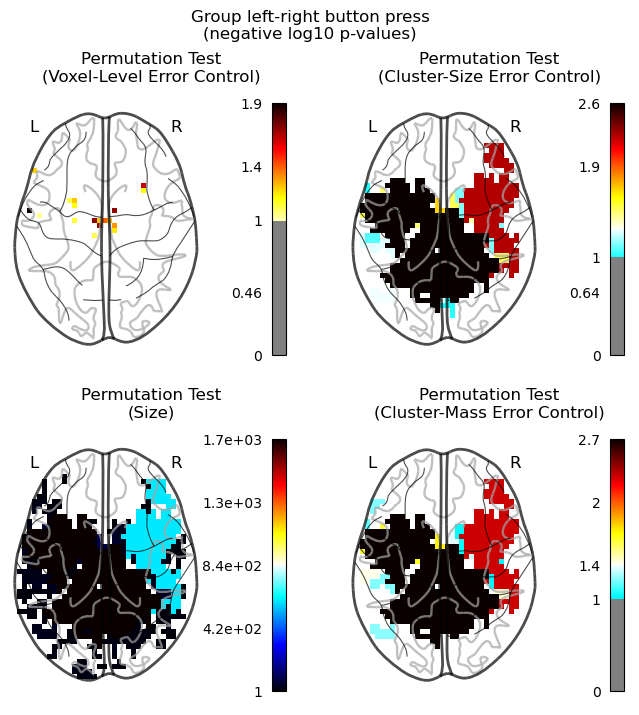

In [ ]:
import itertools
import matplotlib.pyplot as plt

threshold = 1  # p < 0.1
vmax = 2.69  # ~= -np.log10(1 / 500)

cut_coords = [0]

IMAGES = [
    outputs["logp_max_t"],
    outputs["logp_max_size"],
    outputs["size"],
    outputs["logp_max_mass"],
]
TITLES = [
    "Permutation Test\n(Voxel-Level Error Control)",
    "Permutation Test\n(Cluster-Size Error Control)",
    "Permutation Test\n(Size)",
    "Permutation Test\n(Cluster-Mass Error Control)",
]

fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=2)
for img_counter, (i_row, j_col) in enumerate(
    itertools.product(range(2), range(2))
):
    ax = axes[i_row, j_col]
    plotting.plot_glass_brain(
        IMAGES[img_counter],
        colorbar=True,
        display_mode="z",
        plot_abs=False,
        cut_coords=cut_coords,
        threshold=threshold,
        figure=fig,
        axes=ax,
    )
    ax.set_title(TITLES[img_counter])
fig.suptitle("Group left-right button press\n(negative log10 p-values)")
plt.show()


In [8]:
p_map = second_level_model.compute_contrast(variable,output_type="p_value")
t_map = second_level_model.compute_contrast(variable, output_type="stat")



In [9]:
from nilearn import image
import numpy as np

# p-value 맵에서 0.05 이하인 부분만 마스크 생성
mask_img = image.math_img('img < 0.05', img=p_map)

# 마스크를 적용하여 t-statistic 맵 필터링
masked_t_map = image.math_img('img1 * img2', img1=t_map, img2=mask_img)

t_data = image.get_data(masked_t_map)
t_min = np.min(t_data[t_data != 0])  # 0이 아닌 값 중 최소값
t_max = np.max(t_data)

print(f"Minimum t-value (excluding zeros): {t_min}")
print(f"Maximum t-value: {t_max}")
masked_t_map.to_filename(f"{group}_{variable}_{roi}_tmap.nii.gz")

Minimum t-value (excluding zeros): 1.6863147795769546
Maximum t-value: 2.787528827809305


In [22]:
from nilearn.reporting import get_clusters_table
table, label_maps = get_clusters_table(t_map, stat_threshold=1.68, cluster_threshold=5, return_label_maps=True)
table.set_index("Cluster ID", drop=True)
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-64.375,-49.625,-19.0,2.787529,320
1,2,11.625,34.375,-19.0,2.696145,576
2,2a,7.625,26.375,-19.0,2.565766,
3,3,-0.375,26.375,-7.0,2.409346,320


In [24]:
label_maps[0].to_filename(f"{group}_{variable}_{roi}_cluster_label.nii.gz")

In [66]:
from nilearn.glm.second_level import non_parametric_inference


out_dict = non_parametric_inference(
    z_maps,
    design_matrix=design_matrix,
    second_level_contrast=variable,
    n_perm=15000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=False,
    n_jobs=-1,
    verbose=1,
)

Fitting second level model...
Computation of second level model done in 0.13392424583435059 seconds


In [67]:
neg_log10_vfwe_pvals_img = out_dict
neg_log10_vfwe_pvals_img.to_filename(f"{group}_{variable}_{roi}_voxel_not_thresholded.nii.gz")

In [35]:
p_cut_off = 0.05
voxel_p_value_cutoff = -np.log10(p_cut_off)
mask_img = image.math_img(f'img > {voxel_p_value_cutoff}', img=neg_log10_vfwe_pvals_img)
masked_p_map = image.math_img('img1 * img2', img1=neg_log10_vfwe_pvals_img, img2=mask_img)
masked_p_map.to_filename(f"{group}_{variable}_voxel_{p_cut_off}.nii.gz")
logp_max_size = out_dict["logp_max_size"]
logp_max_t = out_dict["logp_max_t"]
cluster_cut_off = 0.05
p_cut_off = 0.005
cluster_p_value_cutoff = -np.log10(cluster_cut_off)  # p-value 0.05에 해당하는 -log10 값
voxel_p_value_cutoff = -np.log10(p_cut_off)
mask_img = image.math_img(f'img > {cluster_p_value_cutoff}', img=logp_max_size)
mask_img2 = image.math_img(f'img > {voxel_p_value_cutoff}', img=logp_max_t)
masked_p_map = image.math_img('img1 * img2', img1=mask_img, img2=mask_img2)
masked_p_map.to_filename(f"voxel_{p_cut_off}_cluster_{cluster_cut_off}_cutoff.nii.gz")